In [10]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [11]:
BASE_DIR = './input/flickr8k'
WORKING_DIR = './working'

# Desired image dimensions
IMAGE_SIZE = (224, 224)
SEQ_LENGTH = 35

# Other training parameters
BATCH_SIZE = 32
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
def createCaptionMap(filename):
    caption_mapping = {}
    text_data = []
    images_to_skip = set()
    
    with open(filename, 'r') as f:
        next(f)
        captions_doc = f.read()

        for line in tqdm(captions_doc.split('\n')):
            lineSplit = line.split(',')
            img_name, caption = lineSplit[0], lineSplit[1:]
            image_id = img_name.split('.')[0]
            # img_name = img_name.split('.')[0]
            caption = " ".join(caption)
            tokens = caption.strip().split()
            
            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                # images_to_skip.add(img_name)
                continue

            if image_id not in images_to_skip: 
                # We will add a start and an end token to each caption
                caption = "startseq " + caption.strip() + " endseq"
                text_data.append(caption)

                if image_id in caption_mapping:
                    caption_mapping[image_id].append(caption)
                else:
                    caption_mapping[image_id] = [caption]
        
        f.close()
    return caption_mapping, text_data

# Load the dataset
captions_mapping, text_data = createCaptionMap("./input/flickr8k/captions.txt")

  0%|          | 0/40456 [00:00<?, ?it/s]

100%|██████████| 40456/40456 [00:00<00:00, 344051.38it/s]


In [13]:
# Create Feature Map

features = {}
directory = os.path.normpath(os.path.join(BASE_DIR, 'Images'))

with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)
    print("Loaded Features Map")

if features == {}:
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    print(model.summary())

    for img_name in tqdm(os.listdir(directory)):
        # Load the image from file
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=IMAGE_SIZE)
        # Convert image pixels to numpy array
        image = img_to_array(image)
        # Reshape data for model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Preprocess image for VGG
        image = preprocess_input(image)
        # Extract features
        feature = model.predict(image, verbose=0)
        # Get image ID
        image_id = img_name.split('.')[0]
        # Store feature
        features[img_name] = feature

    pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

Loaded Features Map


In [14]:
# Vectorizing the text data

# max_length = max(len(caption.split()) for caption in text_data)
max_length = SEQ_LENGTH

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
# Split the dataset into training and validation sets
def train_val_split(caption_data, train_size=0.8, shuffle=True):

    all_images = list(caption_data.keys())
    if shuffle:
        np.random.shuffle(all_images)
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    return training_data, validation_data

train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6472
Number of validation samples:  1619


In [16]:
# Create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            
            for caption in captions:                
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # Split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

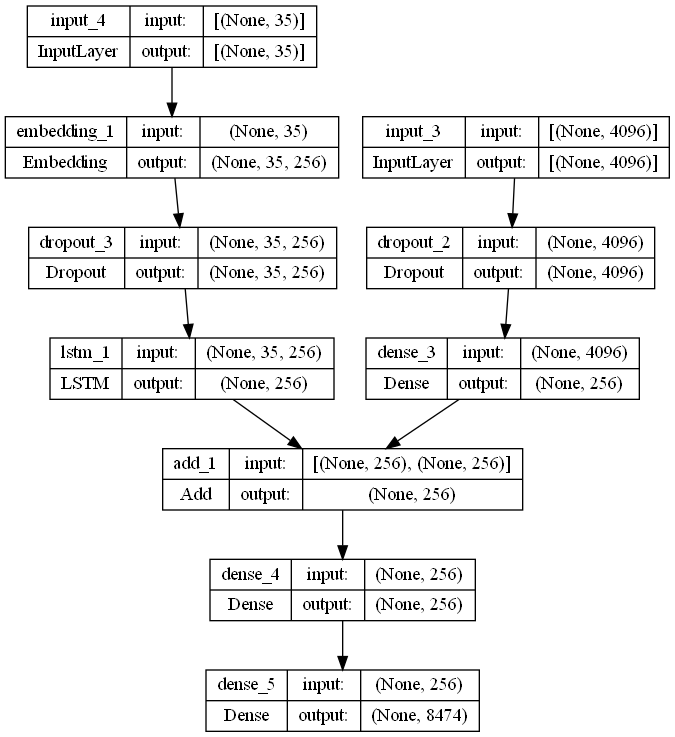

In [17]:
#  Building the Model

# Encoder model
# Image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

In [18]:
# Train the model
steps = len(train_data) // BATCH_SIZE
validation_steps = len(valid_data) // BATCH_SIZE

history = model.fit(
    data_generator(train_data, captions_mapping, features, tokenizer, max_length, vocab_size, BATCH_SIZE),
    epochs=EPOCHS,
    steps_per_epoch=steps,
    validation_data=data_generator(valid_data, captions_mapping, features, tokenizer, max_length, vocab_size, BATCH_SIZE),
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/30
202/202 [==============================] - 637s 3s/step - loss: 4.8589 - val_loss: 4.0019
Epoch 2/30
202/202 [==============================] - 613s 3s/step - loss: 3.5968 - val_loss: 3.5633
Epoch 3/30
202/202 [==============================] - 592s 3s/step - loss: 3.1741 - val_loss: 3.4458
Epoch 4/30
202/202 [==============================] - 585s 3s/step - loss: 2.9216 - val_loss: 3.4364
Epoch 5/30
202/202 [==============================] - 586s 3s/step - loss: 2.7405 - val_loss: 3.4579
Epoch 6/30
202/202 [==============================] - 586s 3s/step - loss: 2.6062 - val_loss: 3.5017
Epoch 7/30
202/202 [==============================] - 584s 3s/step - loss: 2.5059 - val_loss: 3.5479
Epoch 8/30
202/202 [==============================] - 584s 3s/step - loss: 2.4241 - val_loss: 3.5685
Epoch 9/30
202/202 [==============================] - 580s 3s/step - loss: 2.3522 - val_loss: 3.6084
Epoch 10/30
202/202 [==============================] - 580s 3s/step - loss: 2.2921 - val_lo

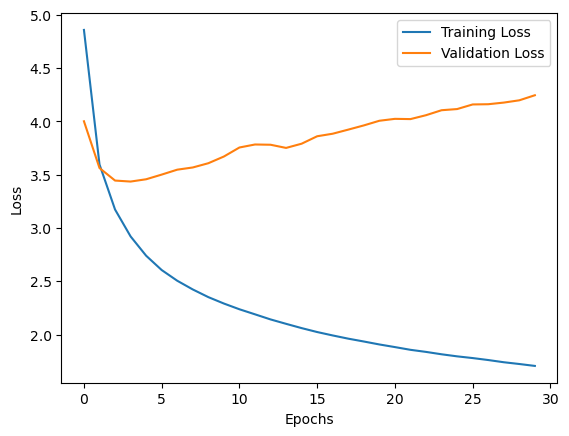

In [19]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Save the model
modelName = "imgCaptioning-Epochs" + str(EPOCHS) + ".h5"
model.save(os.path.join(WORKING_DIR, modelName))